In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from irt import NCFModel, NCF
import torch
import os
device ='cuda:0'
train_data_path = "../data/flickr/processed/train/"
test_data_path = "../data/flickr/processed/test/"
irt_models_path = "../data/flickr/evaluation/irt_models/"
ncf_model_path = "../data/flickr/evaluation/classifier/"
ncf_model_file = "ncf_usrthrs_0.pkl"

In [3]:
ncf = NCF()
ncf.load(f"{ncf_model_path}/{ncf_model_file}")

In [46]:
from diffusers import StableDiffusionPipeline, DDPMScheduler,DDIMInverseScheduler, AutoencoderKL, DDIMScheduler

In [94]:
from torchvision import transforms as tvt
from typing import Optional, Union, Tuple
from PIL import Image
from pathlib import Path

# Stole these from https://github.com/shaibagon/diffusers_ddim_inversion/blob/main/ddim_inversion.py
def load_image(imgname: str, target_size: Optional[Union[int, Tuple[int, int]]] = None) -> torch.Tensor:
    pil_img = Image.open(imgname).convert('RGB')
    if target_size is not None:
        if isinstance(target_size, int):
            target_size = (target_size, target_size)
        pil_img = pil_img.resize(target_size, Image.Resampling.LANCZOS)
    return tvt.ToTensor()(pil_img)[None, ...]  # add batch dimension

def load_image(path: str | Path) -> Image.Image:
    return Image.open(path).convert("RGB").resize((512, 512))

def img_to_latents(x: torch.Tensor, vae: AutoencoderKL):
    x = 2. * x - 1.
    posterior = vae.encode(x).latent_dist
    latents = posterior.mean * 0.18215
    return latents

In [79]:
inverse_scheduler = DDIMInverseScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder='scheduler')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float16
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                                   scheduler=inverse_scheduler,
                                                   safety_checker=None,
                                                   torch_dtype=dtype).to(device)
#pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")
pipe.safety_checker = None
vae = pipe.vae

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [109]:
pipe.unload_ip_adapter()

In [91]:
imgname = "poike.png"
input_img = load_image(imgname, target_size=(224,224)).to(device=device, dtype=dtype)

In [93]:
input_img

tensor([[[[0.3882, 0.4314, 0.4353,  ..., 0.3020, 0.2942, 0.2825],
          [0.3804, 0.4236, 0.4197,  ..., 0.2981, 0.2981, 0.3020],
          [0.4038, 0.3882, 0.3960,  ..., 0.2981, 0.2981, 0.2942],
          ...,
          [0.5371, 0.5449, 0.5527,  ..., 0.5688, 0.5728, 0.5728],
          [0.5371, 0.5410, 0.5527,  ..., 0.5845, 0.5728, 0.5688],
          [0.5332, 0.5449, 0.5527,  ..., 0.5884, 0.5845, 0.5688]],

         [[0.3059, 0.3333, 0.3491,  ..., 0.3372, 0.3254, 0.3176],
          [0.3137, 0.3372, 0.3411,  ..., 0.3254, 0.3372, 0.3333],
          [0.3293, 0.3176, 0.3254,  ..., 0.3293, 0.3372, 0.3254],
          ...,
          [0.5488, 0.5527, 0.5605,  ..., 0.5649, 0.5566, 0.5449],
          [0.5410, 0.5488, 0.5605,  ..., 0.5806, 0.5605, 0.5410],
          [0.5410, 0.5488, 0.5605,  ..., 0.5884, 0.5806, 0.5527]],

         [[0.2510, 0.2627, 0.2864,  ..., 0.3765, 0.3530, 0.3411],
          [0.2627, 0.2744, 0.2825,  ..., 0.3608, 0.3687, 0.3608],
          [0.2864, 0.2666, 0.2783,  ..., 0

In [81]:
latents = img_to_latents(input_img, vae)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.8242188..7.609375].


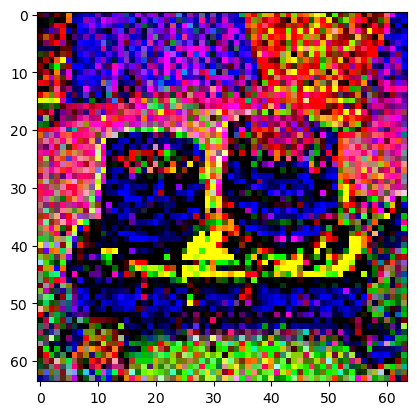

In [82]:
import matplotlib.pyplot as plt
plt.imshow(latents[0,:3].permute(1,2,0).detach().cpu().to(torch.float32))

In [85]:
num_steps = 50
inv_latents, _ = pipe(prompt="", negative_prompt="", guidance_scale=1.,
                          width=input_img.shape[-1], height=input_img.shape[-2],
                          output_type='latent', return_dict=False,
                          num_inference_steps=num_steps, latents=latents)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

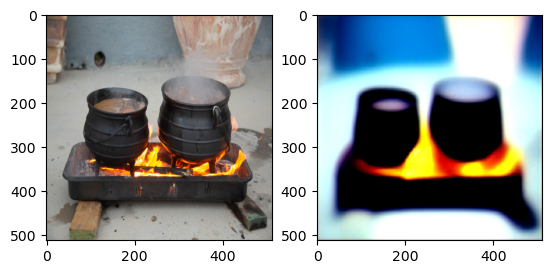

In [86]:
pipe.scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder='scheduler')
image = pipe(prompt="", negative_prompt="", guidance_scale=1.,
                     num_inference_steps=num_steps, latents=inv_latents)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(tvt.ToPILImage()(input_img[0]))
ax[1].imshow(image.images[0])
plt.show()

In [331]:
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")
with torch.inference_mode():
    sampled_img_embs = pipe.encode_image(input_img, device=device, num_images_per_prompt=1)

In [332]:
pos = sampled_img_embs[0].unsqueeze(0).unsqueeze(0)  # (1,1,D)
neg = torch.zeros_like(pos)
ip  = torch.cat([neg, pos], dim=0) 

  0%|          | 0/100 [00:00<?, ?it/s]

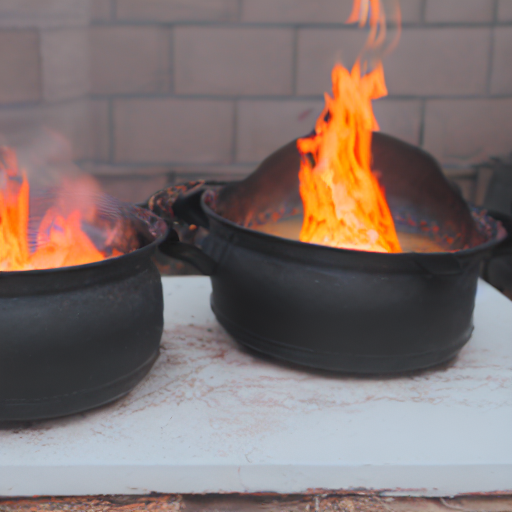

In [411]:
pipe.set_ip_adapter_scale(1.0)
gen = torch.Generator(device=device).manual_seed(seed)
result = pipe(
    prompt="",                               # empty text prompt
    negative_prompt="",                      # no negative either
    ip_adapter_image_embeds=[ip],     # list-of-tensors API
    num_inference_steps=100,
    generator=gen
                     # ignore the (empty) text ctx
).images

result[0]

In [64]:
from prior_models import RebecaDiffusionPrior

rdp = RebecaDiffusionPrior(
    img_embed_dim=1024,
    num_users=210,
    num_tokens=32,
    hidden_dim=256,
    n_heads=8,
    num_layers=8,
).to(device)

rdp_namepath = "modelrdp_num_layers8_num_heads8_hidden_dim256_tokens32_lr0.0001_optadamw_schreduce_on_plateau_bs64_nslaplace_ts1000_spu100_csFalse_objsample_normnone_uthr0.pth"
rdp_dir = "../data/flickr/evaluation/diffusion_priors/models/weights/comprehensive_study_20250830_013540/"

rdp.load_state_dict(torch.load(f"{rdp_dir}/{rdp_namepath}"))


<All keys matched successfully>

In [60]:
noise_scheduler = DDPMScheduler(
                num_train_timesteps=1000,
                beta_schedule="laplace",
                clip_sample=False,
                prediction_type="sample"
            )

In [65]:
from sampling import sample_from_diffusion

embeddings_per_user = 50
user_idx = 0
like = 1
score_tensor = torch.tensor(like).expand(embeddings_per_user).long().to(device)
user_tensor = torch.tensor(user_idx).expand(embeddings_per_user).to(device)
user_uncond   = torch.full_like(user_tensor, fill_value=210).to(device)
score_uncond  = torch.full_like(score_tensor, fill_value=2).to(device)

embeddings = sample_from_diffusion(
    model=rdp,
    user_ids_cond=user_tensor,
    scores_cond=score_tensor,
    user_ids_uncond=user_uncond,
    scores_uncond=score_uncond,
    img_embedding_size=1024,
    scheduler=noise_scheduler,
    guidance_scale=3.0,
    device=device
)

In [145]:
personalized_mean_emb = embeddings.mean(dim=0)
ppos = embeddings[0].unsqueeze(0).unsqueeze(0)  # (1,1,D)
pneg = torch.zeros_like(ppos)
pip  = torch.cat([pneg, ppos], dim=0) 

  0%|          | 0/100 [00:00<?, ?it/s]

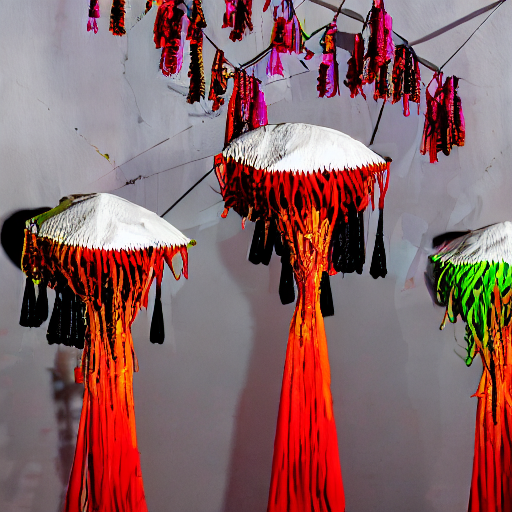

In [150]:
pipe.set_ip_adapter_scale(1.0)
result = pipe(
    prompt="",                               # empty text prompt
    negative_prompt="",    
    guidance_scale=3.0,                  # no negative either
    ip_adapter_image_embeds=[pip],     # list-of-tensors API
    num_inference_steps=100,
    #latents=inv_latents,
                     # ignore the (empty) text ctx
).images

result[0]

In [405]:
def slerp(emb_1, emb_2, t=0.01):
    # Emb 1 stands for the original image embedding
    # Emb 2 stands for the sampled personalized embedding
    p0 = emb_1/emb_1.norm()
    p1 = emb_2/emb_2.norm()

    Omega = torch.arccos((p0 * p1).sum(dim=1))
    slerp = torch.sin((1 - t)*Omega) * p0 + torch.sin(t * Omega) * p1
    slerp /= torch.sin(Omega)
    return slerp * emb_1.norm()


In [435]:
slerp_emb = slerp(sampled_img_embs[0], embeddings.mean(dim=0), t=0.1)
s = sampled_img_embs[0]/sampled_img_embs[0].norm()
slerppos = slerp_emb.unsqueeze(0).unsqueeze(0)  # (1,1,D)
slerpneg = torch.zeros_like(slerppos)
slerpip  = torch.cat([slerpneg, slerppos], dim=0) 

  0%|          | 0/100 [00:00<?, ?it/s]

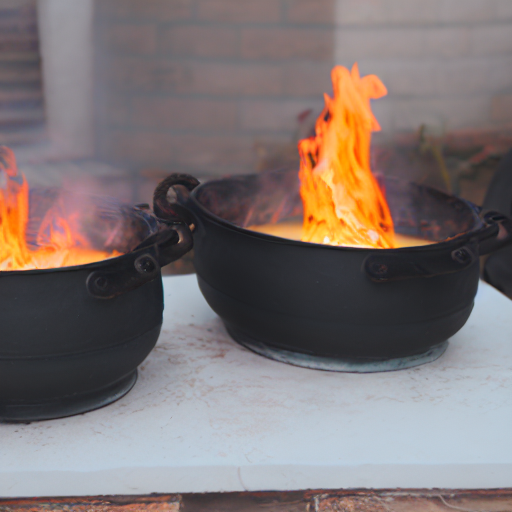

In [436]:
seed = 1
gen = torch.Generator(device=device).manual_seed(seed)

pipe.set_ip_adapter_scale(1.0)
result = pipe(
    prompt="",                               # empty text prompt
    negative_prompt="",    
    #guidance_scale=3.0,                  # no negative either
    ip_adapter_image_embeds=[slerpip],     # list-of-tensors API
    num_inference_steps=100,
    #latents=inv_latents,
    generator=gen,  
).images

result[0]